In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from hiveplotlib import hive_plot_n_axes
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.viz import hive_plot_viz
from matplotlib.lines import Line2D
from scipy import interpolate

Read TSV file

In [3]:
df = pd.read_csv('IMGPR_plasmid_data.tsv', sep='\t')
print("Initial data shape:", df.shape)

Initial data shape: (699973, 24)


Clean and prepare the data<br>
Replace empty strings and 'nan' strings with NaN

In [4]:
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.replace('nan', np.nan)

Extract genus from host_taxonomy

In [5]:
df['genus'] = df['host_taxonomy'].str.extract(r'g__([^;]+)')
print("Unique genera found:", df['genus'].nunique())

Unique genera found: 2177


Handle ARG genes - split only if it contains semicolons

In [6]:
df['arg_genes'] = df['arg_genes'].apply(lambda x: x.split(';') if isinstance(x, str) and ';' in x else [x])
df = df.explode('arg_genes')
print("After exploding ARGs shape:", df.shape)

After exploding ARGs shape: (723607, 25)


Remove rows with missing values and empty strings

In [7]:
df = df.dropna(subset=['arg_genes', 'genus', 'ecosystem'])
df = df[df['arg_genes'].str.len() > 0]
print("After cleaning shape:", df.shape)

After cleaning shape: (2860, 25)


Print sample of data to verify structure

In [8]:
print("\nSample of processed data:")
print(df[['arg_genes', 'genus', 'ecosystem']].head())


Sample of processed data:
     arg_genes           genus  \
2343    RF0134  Staphylococcus   
4488    RF0126     Escherichia   
8234    RF0126     Escherichia   
8518    RF0042  Staphylococcus   
8518    RF0043  Staphylococcus   

                                              ecosystem  
2343  Engineered;Modeled;Simulated communities (cont...  
4488  Host-associated;Mammals: Human;Digestive syste...  
8234                              Engineered;Wastewater  
8518  Engineered;Built environment;City;Subway;Plast...  
8518  Engineered;Built environment;City;Subway;Plast...  


Get unique values for each axis

In [9]:
args_vals = df['arg_genes'].unique()
genus_vals = df['genus'].unique()
ecosystem_vals = df['ecosystem'].unique()

In [10]:
print("\nCounts of unique values:")
print(f"ARGs: {len(args_vals)}")
print(f"Genera: {len(genus_vals)}")
print(f"Ecosystems: {len(ecosystem_vals)}")


Counts of unique values:
ARGs: 62
Genera: 87
Ecosystems: 80


Create graph

In [11]:
G = nx.Graph()

Create nodes and edges only if we have valid data


Nodes by type:
ARG nodes: 62
Genus nodes: 87
Eco nodes: 80

Graph info:
Nodes: 229
Edges: 771

Node groups:
ARG nodes: 62
Genus nodes: 87
Eco nodes: 80


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



Pathogenic proportions in top genera:
Staphylococcus: 551/1571 (35.1%)
Klebsiella: 4/208 (1.9%)
Parabacteroides: 0/184 (0.0%)
ER4: 0/143 (0.0%)
Escherichia: 0/98 (0.0%)
Parasutterella: 0/88 (0.0%)
Pseudomonas: 81/81 (100.0%)
UBA1417: 0/63 (0.0%)
Fusobacterium_A: 0/40 (0.0%)
Streptococcus: 3/29 (10.3%)


<Figure size 2000x1000 with 0 Axes>

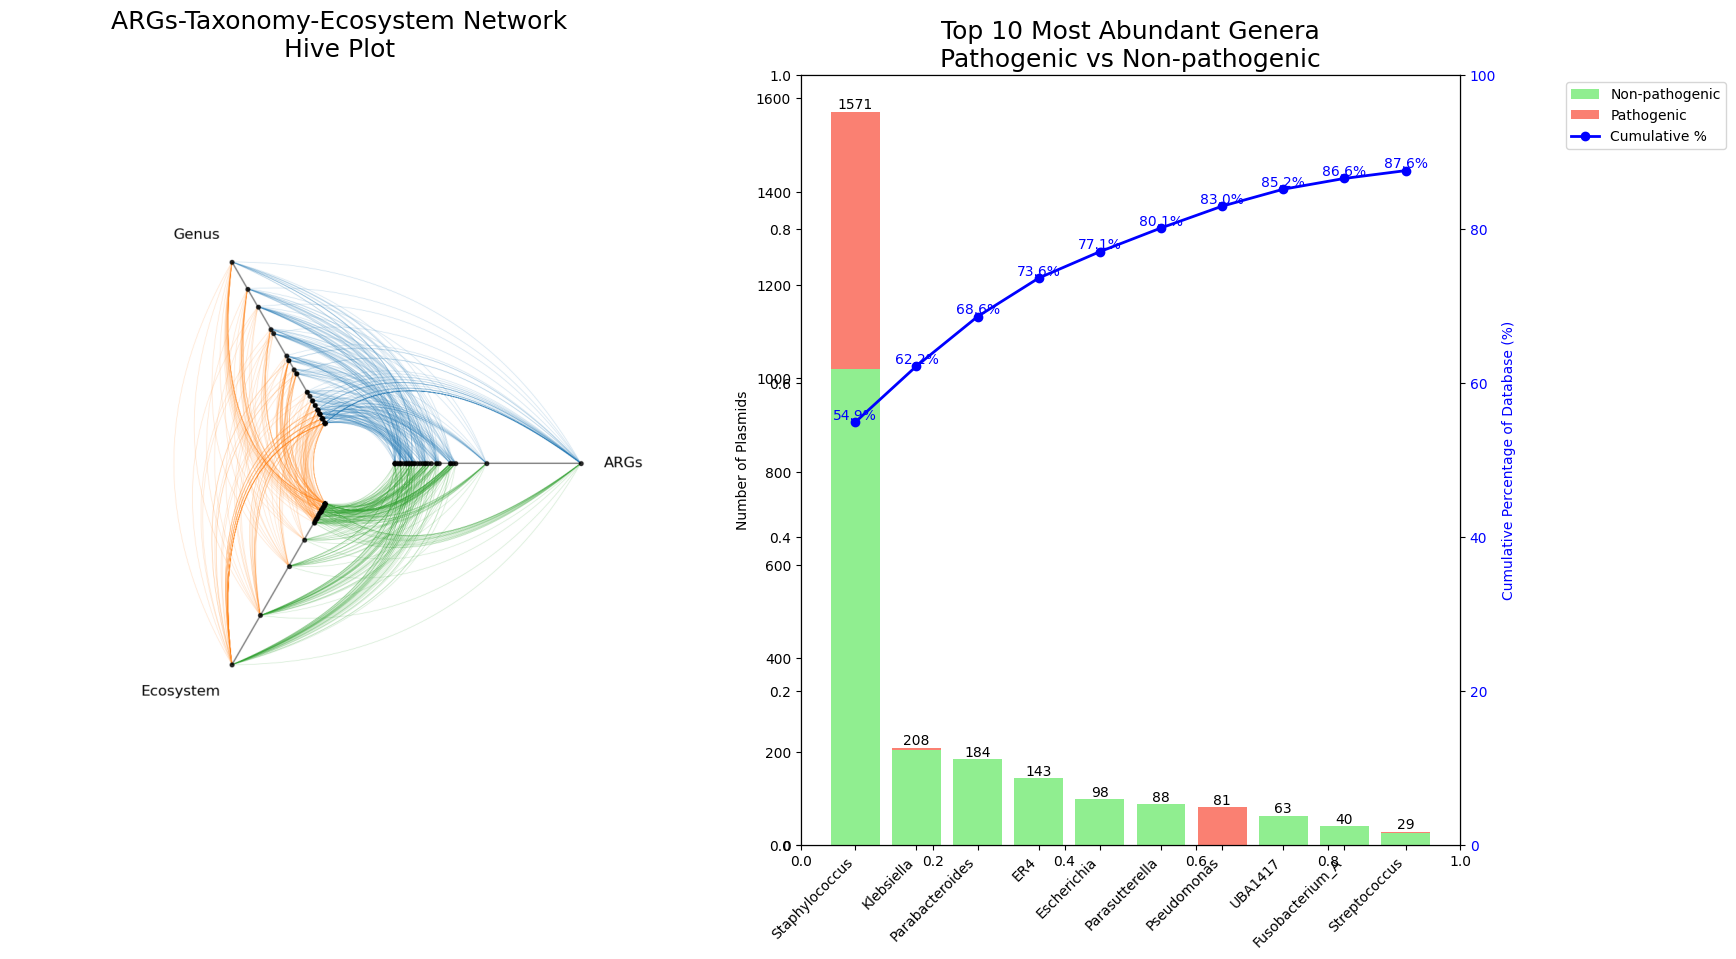

In [12]:
if len(args_vals) > 0 and len(genus_vals) > 0 and len(ecosystem_vals) > 0:
    # Create nodes with proper prefixes
    for arg in args_vals:
        G.add_node(f"arg_{arg}", type='arg')
    for genus in genus_vals:
        G.add_node(f"genus_{genus}", type='genus')
    for eco in ecosystem_vals:
        G.add_node(f"eco_{eco}", type='eco')  # Changed prefix to match type
    print("\nNodes by type:")
    print("ARG nodes:", len([n for n in G.nodes if n.startswith('arg_')]))
    print("Genus nodes:", len([n for n in G.nodes if n.startswith('genus_')]))
    print("Eco nodes:", len([n for n in G.nodes if n.startswith('eco_')]))

    # Create edges
    for _, row in df.iterrows():
        G.add_edge(f"arg_{row['arg_genes']}", f"genus_{row['genus']}")
        G.add_edge(f"genus_{row['genus']}", f"eco_{row['ecosystem']}")
        G.add_edge(f"eco_{row['ecosystem']}", f"arg_{row['arg_genes']}")
    print(f"\nGraph info:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    if G.number_of_nodes() > 0 and G.number_of_edges() > 0:
        # Convert to hiveplotlib format
        nodes, edges = networkx_to_nodes_edges(G)

        # Add node data
        for node in nodes:
            prefix = node.unique_id.split('_')[0]
            node.add_data(data={
                "type": prefix,
                "degree": len(G[node.unique_id])
            })

        # Create group assignments - using startswith instead of checking data["type"]
        arg_nodes = [n.unique_id for n in nodes if n.unique_id.startswith('arg_')]
        genus_nodes = [n.unique_id for n in nodes if n.unique_id.startswith('genus_')]
        eco_nodes = [n.unique_id for n in nodes if n.unique_id.startswith('eco_')]
        print("\nNode groups:")
        print(f"ARG nodes: {len(arg_nodes)}")
        print(f"Genus nodes: {len(genus_nodes)}")
        print(f"Eco nodes: {len(eco_nodes)}")

        # Sort nodes by degree
        arg_nodes.sort(key=lambda x: -G.degree[x])  # Sort in descending order
        genus_nodes.sort(key=lambda x: -G.degree[x])
        eco_nodes.sort(key=lambda x: -G.degree[x])

        # Create hive plot
        hp = hive_plot_n_axes(
            node_list=nodes,
            edges=edges,
            axes_assignments=[arg_nodes, genus_nodes, eco_nodes],
            sorting_variables=["degree"] * 3,
            axes_names=["ARGs", "Genus", "Ecosystem"],
            all_edge_kwargs={"lw": 0.5, "alpha": 0.3},
            repeat_axes=[False] * 3,
            orient_angle=0,
        )

        # Customize edge colors based on connection type
        hp.add_edge_kwargs(axis_id_1="ARGs", axis_id_2="Genus", color="C0")
        hp.add_edge_kwargs(axis_id_1="Genus", axis_id_2="Ecosystem", color="C1")
        hp.add_edge_kwargs(axis_id_1="Ecosystem", axis_id_2="ARGs", color="C2")

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 10))
        
        # Create hive plot first
        hp_fig, hp_ax = hive_plot_viz(hp)
        
        # Create a new figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Copy hive plot data to first subplot
        hp_fig.canvas.draw()
        ax1.imshow(np.asarray(hp_fig.canvas.buffer_rgba()))
        ax1.axis('off')
        ax1.set_title("ARGs-Taxonomy-Ecosystem Network\nHive Plot", fontsize=18, y=1.1)
        plt.close(hp_fig)  # Close the original hive plot
        
        # Define comprehensive human pathogenic species by genus
        pathogenic_species = {
            'Escherichia': [
                'coli O157:H7', 'coli O104:H4', 'coli O26', 'coli O111', 
                'coli ETEC', 'coli EPEC', 'coli EAEC', 'coli EIEC'
            ],
            'Klebsiella': [
                'pneumoniae', 'oxytoca', 'aerogenes'
            ],
            'Salmonella': [
                'enterica', 'typhi', 'typhimurium', 'enteritidis', 
                'paratyphi', 'choleraesuis'
            ],
            'Enterobacter': [
                'cloacae', 'aerogenes', 'sakazakii'
            ],
            'Acinetobacter': [
                'baumannii', 'calcoaceticus', 'nosocomialis'
            ],
            'Pseudomonas': [
                'aeruginosa', 'putida', 'fluorescens'
            ],
            'Staphylococcus': [
                'aureus', 'epidermidis', 'saprophyticus', 
                'haemolyticus', 'lugdunensis'
            ],
            'Streptococcus': [
                'pyogenes', 'pneumoniae', 'agalactiae', 
                'mutans', 'suis', 'bovis'
            ],
            'Enterococcus': [
                'faecalis', 'faecium', 'gallinarum'
            ],
            'Citrobacter': [
                'freundii', 'koseri', 'rodentium'
            ]
        }

        # Get top 10 genera
        top_genera = df['genus'].value_counts().head(10)
        
        # Calculate pathogenic vs non-pathogenic counts for each genus
        path_counts = []
        non_path_counts = []
        
        # Extract species information from taxonomy
        for genus in top_genera.index:
            genus_data = df[df['genus'] == genus]
            pathogenic_count = 0
            
            if genus in pathogenic_species:
                # Search for pathogenic species in taxonomy string
                pathogenic_count = genus_data['host_taxonomy'].str.contains(
                    '|'.join(f"s__{genus} {sp}" for sp in pathogenic_species[genus]), 
                    regex=True
                ).sum()
            
            total_count = len(genus_data)
            non_pathogenic_count = total_count - pathogenic_count
            
            path_counts.append(pathogenic_count)
            non_path_counts.append(non_pathogenic_count)

        # Print pathogenic proportions for verification
        print("\nPathogenic proportions in top genera:")
        for genus, total, path in zip(top_genera.index, top_genera.values, path_counts):
            print(f"{genus}: {path}/{total} ({(path/total)*100:.1f}%)")

        # Calculate cumulative percentages
        total_plasmids = len(df)
        cumulative_percentages = (top_genera.cumsum() / total_plasmids) * 100

        # Create stacked bar plot
        ax2 = fig.add_subplot(122)
        x = range(len(top_genera))
        
        # Create stacked bars
        bars_non_path = ax2.bar(x, non_path_counts, color='lightgreen', label='Non-pathogenic')
        bars_path = ax2.bar(x, path_counts, bottom=non_path_counts, color='salmon', label='Pathogenic')
        
        # Create second y-axis for percentages
        ax2_percent = ax2.twinx()
        ax2_percent.set_ylim(0, 100)
        ax2_percent.set_ylabel('Cumulative Percentage of Database (%)', color='blue')
        ax2_percent.tick_params(axis='y', labelcolor='blue')
        
        # Plot cumulative percentage line
        line = ax2_percent.plot(x, cumulative_percentages, 'bo-', linewidth=2, label='Cumulative %')
        
        # Customize primary axis
        ax2.set_xticks(x)
        ax2.set_xticklabels(top_genera.index, rotation=45, ha='right')
        ax2.set_title('Top 10 Most Abundant Genera\nPathogenic vs Non-pathogenic', fontsize=18)
        ax2.set_ylabel('Number of Plasmids')

        # Add value labels
        for i, (total, cum_pct) in enumerate(zip(top_genera, cumulative_percentages)):
            # Total count label
            ax2.text(i, total, f'{int(total)}',
                    ha='center', va='bottom')
            # Cumulative percentage label
            ax2_percent.text(i, cum_pct, f'{cum_pct:.1f}%',
                           ha='center', va='bottom', color='blue')

        # Combine legends
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_percent.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, 
                  loc='upper left', bbox_to_anchor=(1.15, 1))

        # Adjust layout
        plt.subplots_adjust(right=0.85)

        # Save and show plot
        plt.savefig('ARGs_Taxonomy_Ecosystem_analysis.pdf', 
                   format='pdf', 
                   bbox_inches='tight', 
                   dpi=300)
        plt.savefig('ARGs_Taxonomy_Ecosystem_analysis.png', 
                   format='png', 
                   bbox_inches='tight', 
                   dpi=300)
        
        plt.show()
    else:
        print("Error: Graph has no nodes or edges")
else:
    print("Error: No valid data found for one or more categories")

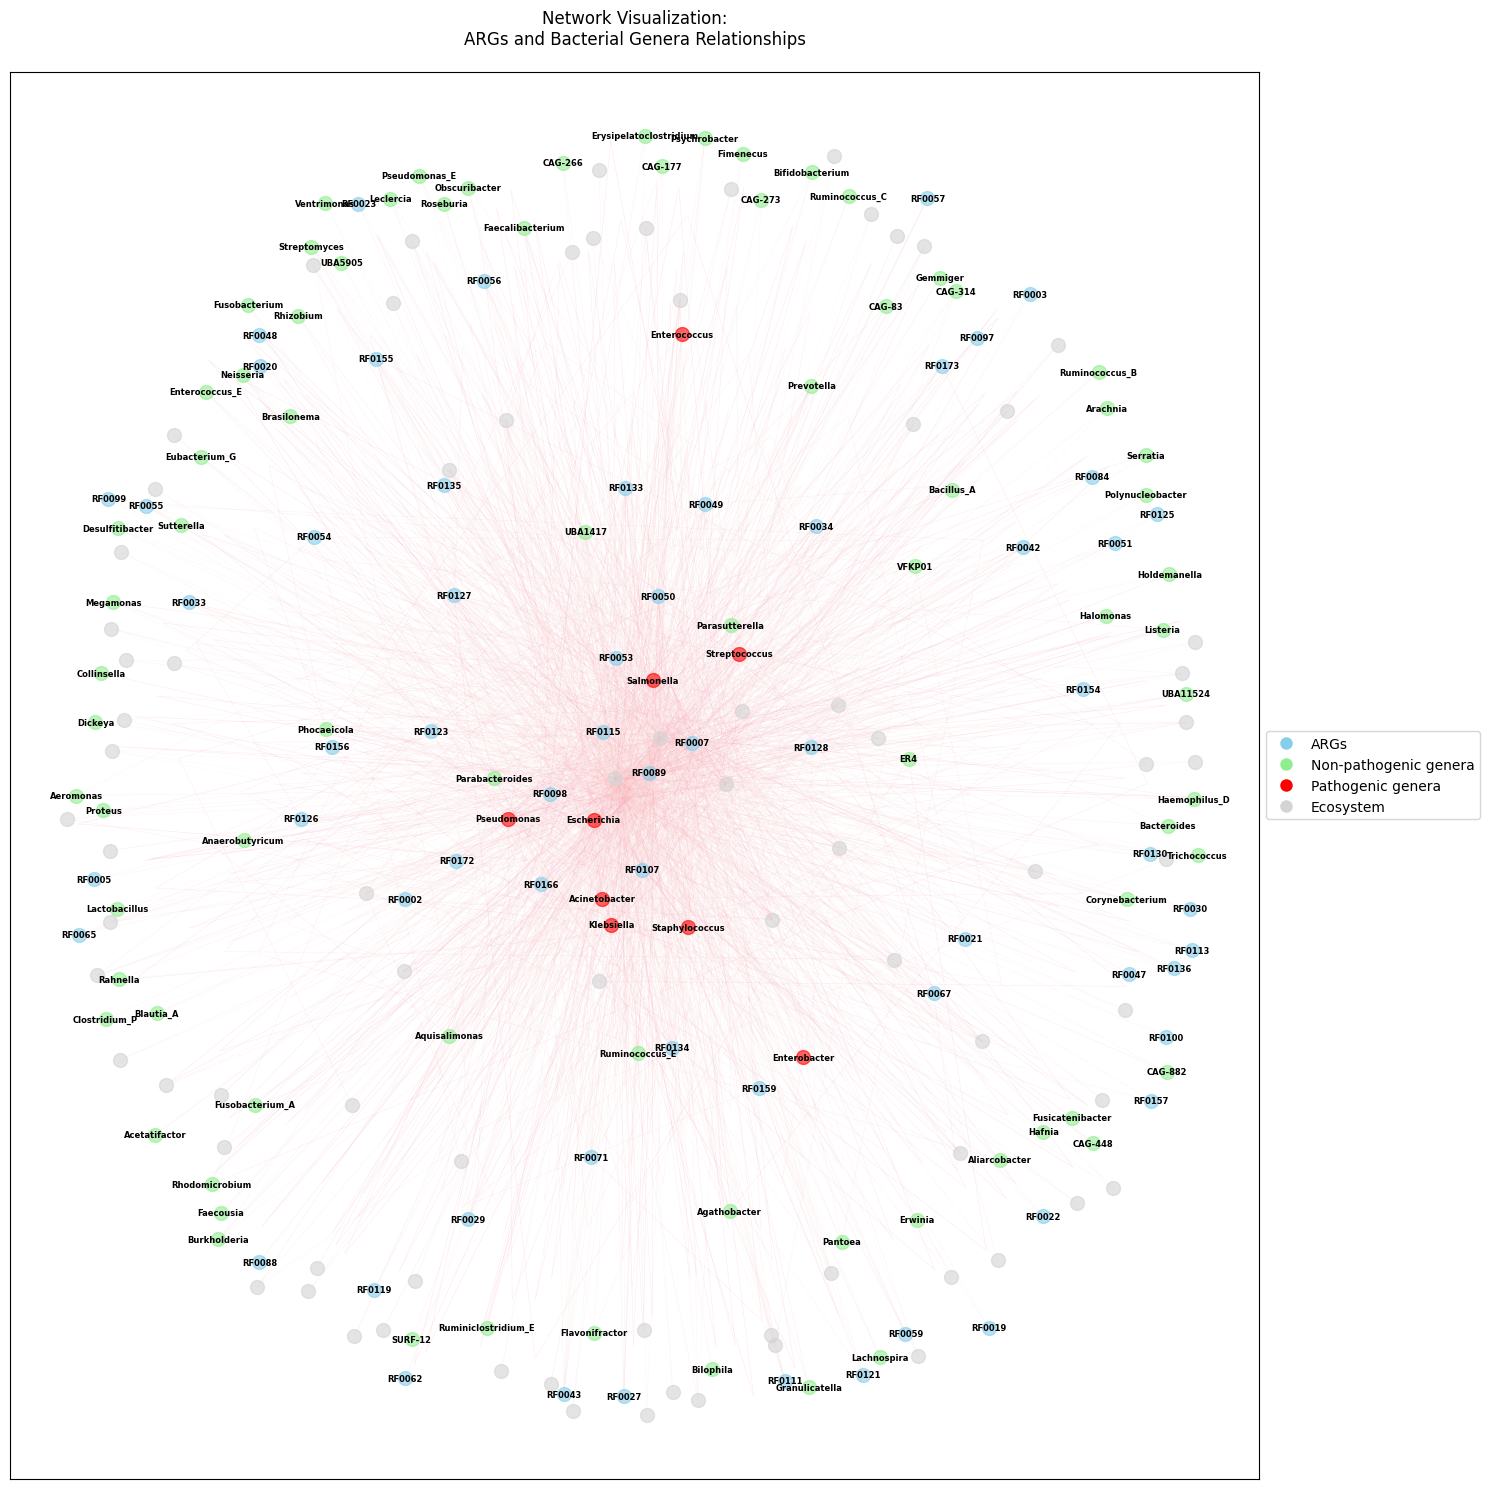

In [52]:
# Import required libraries 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Create graph using spring layout
G = nx.Graph()

# Add nodes and edges to your graph
for node in genus_nodes + eco_nodes + arg_nodes:
    G.add_node(node)
    
for edge in edges:
    G.add_edge(edge[0], edge[1])

# Create spring layout with adjusted parameters
pos = nx.spring_layout(G, k=1, iterations=50)

# Set parameters for edge bundling
pull_strength = 1

# Create adjacency matrix for clustering
adj_matrix = nx.adjacency_matrix(G).todense()

# Compute distance matrix
distances = pdist(adj_matrix, metric='euclidean')
# Create linkage matrix
# Create a hierarchical bundling visualization
plt.figure(figsize=(15, 15))

# Create hierarchical edge bundling effect
for (u, v) in G.edges():
    # Get control points for the curve
    start = np.array(pos[u])
    end = np.array(pos[v])
    
    # Calculate midpoint and pull it towards center for bundling effect
    np.array([0, 0])  # Create a center point at origin
    mid = (start + end) / 2
    to_center = -mid / np.linalg.norm(mid) * pull_strength
    
    # Create Bezier curve points
    path = [(start[0], start[1]),
            (mid[0] + to_center[0], mid[1] + to_center[1]),
            (end[0], end[1])]
    
    # Color edges based on their position in the bundling
    # This creates a gradient effect similar to RdPu palette
    pos_norm = np.linalg.norm(mid + to_center)
    color = plt.cm.RdPu(pos_norm / 2)
    
    # Draw the bundled edge
    plt.plot(*zip(*path), color=color, alpha=0.2, linewidth=0.3)

# Draw nodes and labels as before
# Draw the nodes at their original positions with size and color based on type
for node in G.nodes():
    if node.startswith('arg_'):
        nx.draw_networkx_nodes(G, pos, [node], node_color='skyblue', 
                             node_size=100, alpha=0.6)
    elif node.startswith('genus_'):
        # Check if genus is pathogenic
        genus = node.replace('genus_', '')
        is_pathogenic = any(genus in path_genus for path_genus in pathogenic_species.keys())
        color = 'red' if is_pathogenic else 'lightgreen'
        nx.draw_networkx_nodes(G, pos, [node], node_color=color, 
                             node_size=100, alpha=0.6)
    elif node.startswith('eco_'):
        nx.draw_networkx_nodes(G, pos, [node], node_color='lightgray', 
                             node_size=100, alpha=0.6)

labels = {}
for node in G.nodes():
    if not node.startswith('eco_'):
        if node.startswith('arg_'):
            labels[node] = node.replace('arg_', '')
        elif node.startswith('genus_'):
            labels[node] = node.replace('genus_', '')
            
nx.draw_networkx_labels(G, pos, labels,
                       font_size=6,
                       font_weight='bold')

# Update legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='ARGs',
               markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Non-pathogenic genera',
               markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Pathogenic genera',
               markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Ecosystem',
               markerfacecolor='lightgray', markersize=10)
]

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Network Visualization:\nARGs and Bacterial Genera Relationships', pad=20)

plt.tight_layout()
plt.savefig('network_visualization.png', dpi=300, bbox_inches='tight')
plt.savefig('network_visualization.pdf', format='pdf', bbox_inches='tight')
plt.show()
